In [23]:
# std
import csv
import os
import timeit
from collections import defaultdict
from functools import partial
from tempfile import NamedTemporaryFile
# 3rd party
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
from openpyxl import Workbook
# excelr
from excelr import to_excel

sns.set_theme(style="whitegrid")

data = {}

for filename in os.scandir('data'):
    with open(filename) as f:
        values = list(csv.reader(f))
        key = int(filename.name.split(' ')[0]) * len(values[0])
        data[key] = values
        
with NamedTemporaryFile('wb', delete=False, suffix='.xlsx') as s:
    pass

def openpyxl_write_only(n):
    wb = Workbook(write_only=True)
    ws = wb.create_sheet()
    for r in data[n]:
        ws.append(r)
    wb.save(s.name)
    
def pandas(n):
    pd.DataFrame((x for x in data[n]), columns=data[n][0]).to_excel(s.name)
    
def excelr(n):
    to_excel(s.name, data[n])
    
def memit(fn, n):
    usage = memory_usage((fn, (n,)))
    return max(usage) - min(usage)

def plot(result, ylabel):
    g = sns.lineplot(
        data=result,
        x="x",
        y="y",
        hue="lib"
    )
    g.set(xlabel='# cells', ylabel=ylabel)
    g.legend().set_title("")
    plt.savefig(f"img/{ylabel}.png")

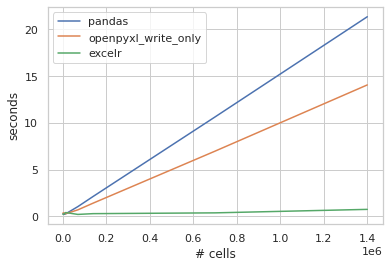

In [26]:
timeit_result = pd.DataFrame(
    {
        'lib': lib,
        'x': x,
        'y': timeit.Timer(f'{lib}({x})', globals=globals()).autorange()[1]
    }
    for x in data
    for lib in ['pandas', 'openpyxl_write_only', 'excelr']
)

plot(timeit_result, 'seconds')

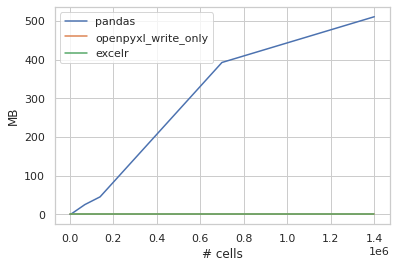

In [24]:
memit_result = pd.DataFrame(
    {
        'lib': lib,
        'x': x,
        'y': memit(globals()[lib], x)
    }
    for x in data
    for lib in ['pandas', 'openpyxl_write_only', 'excelr']
)
plot(memit_result, 'MB')